last edited by Claire Valva on September 27, 2018

# Windowing tests/comparison of results

In [1]:
#import packages
import numpy as np
from scipy.signal import get_window, csd
from scipy.signal.windows import hann, hanning, nuttall, flattop, get_window
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import matplotlib.pyplot as plt
import scipy.integrate as sciint
import pandas as pd
import datetime
import matplotlib.cm as cm
from math import pi
import matplotlib.ticker as tck
import datetime
from sympy import solve, Poly, Eq, Function, exp, re, im
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.optimize import fsolve
import statsmodels.api as sm
from IPython.display import display, Markdown, Latex
import pickle

In [2]:
#import own functions from functions_forspectralanalysis.py
#functions are based off of those in spectral_analysis_tests.ipynb 
#but edited so that they can be used in multiple notebooks
from functions_forspectralanalysis import *

/home/clairev/python-climate-data-processing/submission_from_claire/40.5N-processing/functions_forspectralanalysis.py:84: RuntimeWarning: divide by zero encountered in true_divide
  zonal_spacing = 1/zonal_spacing


[NbConvertApp] Converting notebook functions_forspectralanalysis.ipynb to script
[NbConvertApp] Writing 5754 bytes to functions_forspectralanalysis.py


## get detrended data 
data was processed in 40.5N-spectralanalysis.ipynb

In [3]:
#get detrended data
file_Name = "test_trends_pickle"
    
file_pickle = open(file_Name, "rb")
    
trends_all_list = pickle.load(file_pickle)

In [4]:
#pull everything out of the list
season_index = [sublist[0] for sublist in trends_all_list]
year_index = [sublist[1] for sublist in trends_all_list]
trend_index = [sublist[2] for sublist in trends_all_list]
adjcof_index = [sublist[3] for sublist in trends_all_list]
untrend_index = [sublist[4] for sublist in trends_all_list]

#flatten list of detrended z values
flatten_df_untrend = [item for sublist in untrend_index for item in sublist]
flatten_df_untrend = [item for sublist in flatten_df_untrend for item in sublist]

#get list of same length for df binding - season, year, lon lists
season_df_list = []
year_df_list = []
lon_df_list = []

for i in range(len(untrend_index)):
    for j in range(len(untrend_index[i])):
        for k in range(240):
            entry = season_index[i]
            yr = year_index[i]
            lon = lon_list[k]
            
            season_df_list.append(entry)
            year_df_list.append(yr)
            lon_df_list.append(lon)

d = {"season": season_df_list, "year": year_df_list,
     "lon": lon_df_list, "adj_z": flatten_df_untrend}

untrend_df = pd.DataFrame(d)

## look at windows I am interested in

will do a flattop window, a hanning window, a blackman-harris/nuttall window also


some notes/copy paste from: https://holometer.fnal.gov/GH_FFT.pdf 

hanning: The Hanning window has reasonably low spectral leakage and bandwidth and is hence used as
standard window function in many commercial spectrum analyzers, if amplitude accuracy for
sinusoidal signals is not important (i.e. in noise measurements).

overlap = 50%

nuttall: The Blackman-Harris window has very low spectral leakage combined with reasonable bandwidth
and amplitude error. Due to its small sidelobes it is suitable for the detection of small sinusoidal
signals adjacent in frequency to large signals. It can also be used as a general-purpose window
in applications with high dynamic range if amplitude accuracy for sinusoidal signals is not very
important. Note, however, that two of the Nuttall windows (called ‘Nuttall4b’ and ‘Nuttall4c’,
see next Section C.7) have even lower sidelobes with the same number of cosine terms and
otherwise comparable properties.

overlap = 65.6

##### actually ignore flattop - for measurement systems generally, not appropriate for this analysis
flattop: just looking at to see that it maintains the amplitude -- although I likely will not use it
overlap = 84% 


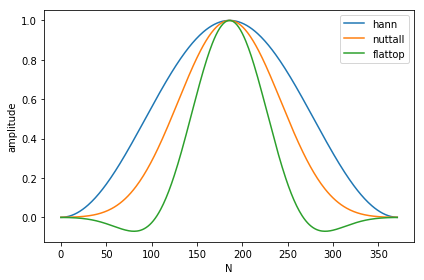

In [5]:
## look at windows next to each other in matplotlib
M = 372
plt.clf()
plt.plot(hann(M, sym = False), label = "hann")
plt.plot(nuttall(M, sym = False), label = "nuttall")
plt.plot(flattop(M, sym = False), label = "flattop")
plt.xlabel('N')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()

### try windows on some sample data

In [6]:
def fftandwindow(numbers, window, M = 372):
    #gets the time fft with same zero padding for all slices, uses hanning window
    
    num_entries = len(numbers)
    
    #if no window, just get coefficients, otherwise convolve the window
    if window == "none":
        fft_coeff = fft(numbers, n = M) 
    else:
        window = get_window(window, num_entries, fftbins = True)
        fft_for = numbers*window
        fft_coeff = fft(fft_for, n = M) 
    
    return(fft_coeff)

In [7]:
#get some test data to use
year_test = 2002
season_test = "spring"
lon_test = 9

test_data = np.real(untrend_df.query(query_string(year_test, season_test, lon_test))["adj_z"])

In [8]:
#apply fft for different windows
windows_list = ["none", "hann", "nuttall", "flattop"]

ffts = [fftandwindow(test_data, window) for window in windows_list]

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


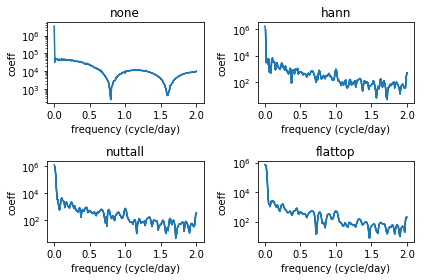

In [9]:
#plot ffts
plt.clf()

for i in range(4):
    plt.subplot(2,2,1 + i)
    plt.plot(np.abs(fftfreq(M, 0.25)), np.abs(ffts[i]), label = windows_list[i])
    plt.title(windows_list[i])
    plt.xlabel('frequency (cycle/day)')
    plt.ylabel('coeff')
    plt.yscale("log")

plt.tight_layout()
plt.show()

### try windows with appropriate amount of overlap -- no more flattop

will do 3 windows because?

for a given overlap, the total length should be = 1/overlap percent * length of windows

In [10]:
windows_list = ["none", "hann", "nuttall"]

In [11]:
def splitter(data, over_per):
    #with a given percent overlap, splits the data
    len_dat = len(test_data)
    overlap_recip = 1/over_per
    len_part = len_dat / overlap_recip
    endpart1 = int(len_part)
    startpart2 = int(endpart1*(1-over_per))
    endpart2 = len_part*over_per + len_part
    endpart2 = int(endpart2)
    
    #test overlaps to make sure it looks right
    len1 = test_data[0:endpart1]
    len2 = test_data[startpart2:endpart2]
    len3 = test_data[endpart1:len_dat]
    
    return len1, len2, len3

In [ ]:
window = get_window(window, num_entries, fftbins = True)
fft_for = numbers*window

In [19]:
def windowapp(data, over_per, window):
    
    len1, len2, len3 = splitter(data, over_per)
    
    total_length = len(data)
    pad_length = len(data) - len(len1)
    pad_length = int(pad_length/2)
    pad_list = [0 for i in range(pad_length)]
    
    listed = [len1, len2, len3]
    
    windowed = [length*get_window(window, len(length), fftbins = True ) for length in listed]
    
    len1 = np.concatenate([windowed[0], pad_list, pad_list], axis = 0)
    len2 = np.concatenate([pad_list,windowed[1],pad_list])
    len3 = np.concatenate([pad_list,pad_list,windowed[2]])
    
    listed = [len1, len2, len3]
    
    ffts = [fft(length,n = M ) for length in listed]
    
    return listed, ffts

In [22]:
ffts = [windowapp(test_data, 0.5, "hann")[1], windowapp(test_data, 0.65, "nuttall")[1]]
lens = [windowapp(test_data, 0.5, "hann")[0], windowapp(test_data, 0.65, "nuttall")[0]]

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[index]


#### plot to make sure lengths were split correctly

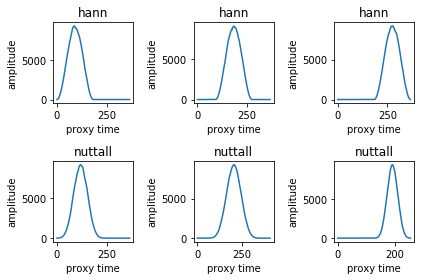

In [23]:
plt.clf()

for row in range(2):
    for col in range(3):
        if row > 0:
            count = col + 3
        else:
            count = col
        
        plt.subplot(2,3,1+count)
        plt.plot(lens[row][col])
        plt.title(windows_list[1+row])
        plt.xlabel("proxy time")
        plt.ylabel("amplitude")
        
plt.tight_layout()
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


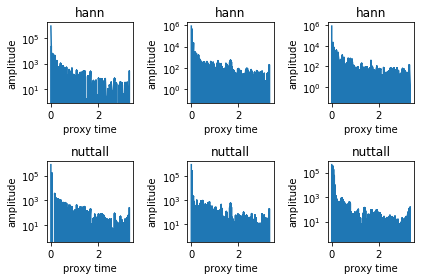

In [24]:
plt.clf()

for row in range(2):
    for col in range(3):
        if row > 0:
            count = col + 3
        else:
            count = col
        
        plt.subplot(2,3,1+count)
        plt.plot(np.abs(fftfreq(M, 0.15)), ffts[row][col])
        plt.title(windows_list[1+row])
        plt.yscale("log")
        plt.xlabel("proxy time")
        plt.ylabel("amplitude")
        
plt.tight_layout()
plt.show()

so there is less bleeding with the nuttall window -- but maybe that is just because it is super small sampled - split it to two?

In [27]:
def splitter_2part(data, over_per, window):
    #with a given percent overlap, splits the data
    half = len(test_data)/2

    endpart1 = int(half + half*over_per)
    startpart2 = int(half - half*over_per)
    
    #test overlaps to make sure it looks right
    len1 = test_data[0:endpart1]
    len2 = test_data[startpart2:len(data)]
    listed = [len1, len2]
    
    #window it
    len1, len2 = [length*get_window(window, len(length), fftbins = True ) for length in listed]
    
    padding = len(data) - len(len1)
    zero_list = [0 for i in range(padding)]
    len1 = np.concatenate([len1, zero_list])
    len2 = np.concatenate([zero_list, len2])
    
    
    return len1, len2

In [30]:
lens2 = [splitter_2part(test_data, 0.5, "hann"),splitter_2part(test_data, 0.65, "nuttall") ]


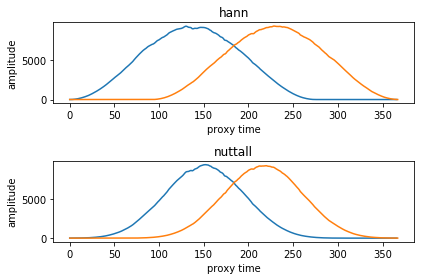

In [31]:
plt.clf()

for col in range(2):
    plt.subplot(2,1,1+col)
    plt.plot(lens2[col][0])
    plt.plot(lens2[col][1])
    plt.title(windows_list[1+col])
    plt.xlabel("proxy time")
    plt.ylabel("amplitude")

plt.tight_layout()
plt.show()

In [37]:
def windowapp2(data, over_per, window):
    listed = splitter_2part(data, over_per, window)
    ffts = [fft(length, n = M) for length in listed]
    
    return ffts

In [38]:
ffts2 = [windowapp2(test_data, 0.5, "hann"), windowapp2(test_data, 0.65, "nuttall")]

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


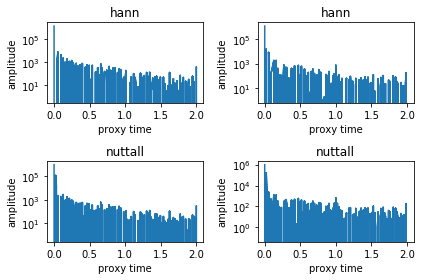

In [42]:
plt.clf()

for col in range(2):
    for row in range(2):
        if col > 0:
            count = col + 1
        else:
            count = col
        
        plt.subplot(2,2,1 + count + row)
        plt.plot(np.abs(fftfreq(M,0.25)), ffts2[col][row])
        plt.title(windows_list[1+col])
        plt.yscale("log")
        plt.xlabel("proxy time")
        plt.ylabel("amplitude")

plt.tight_layout()
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


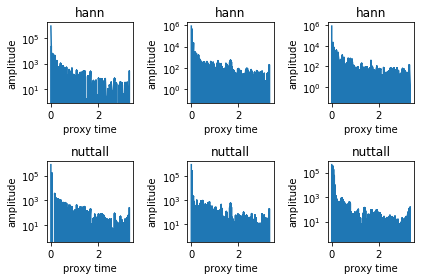

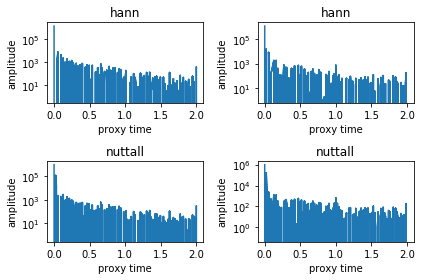

In [45]:
plt.clf()

for row in range(2):
    for col in range(3):
        if row > 0:
            count = col + 3
        else:
            count = col
        
        plt.subplot(2,3,1+count)
        plt.plot(np.abs(fftfreq(M, 0.15)), ffts[row][col])
        plt.title(windows_list[1+row])
        plt.yscale("log")
        plt.xlabel("proxy time")
        plt.ylabel("amplitude")
        
plt.tight_layout()
plt.show()

plt.clf()

for col in range(2):
    for row in range(2):
        if col > 0:
            count = col + 1
        else:
            count = col
        
        plt.subplot(2,2,1 + count + row)
        plt.plot(np.abs(fftfreq(M,0.25)), ffts2[col][row])
        plt.title(windows_list[1+col])
        plt.yscale("log")
        plt.xlabel("proxy time")
        plt.ylabel("amplitude")

plt.tight_layout()
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


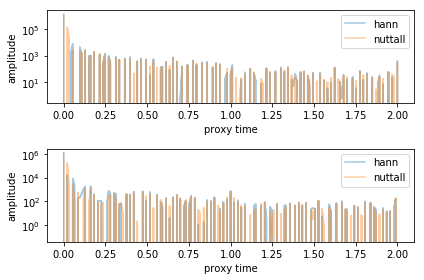

In [43]:
plt.clf()

for row in range(2):

    plt.subplot(2,1,1+row)
    plt.plot(np.abs(fftfreq(M,0.25)), ffts2[0][row], label = windows_list[1], alpha = 0.4)
    plt.plot(np.abs(fftfreq(M,0.25)), ffts2[1][row], label = windows_list[2], alpha = 0.4)
    plt.yscale("log")
    plt.legend()
    plt.xlabel("proxy time")
    plt.ylabel("amplitude")
    
plt.tight_layout()
plt.show()

nuttall window seems to have slightly more resolution/difference in peaks -- so will use that instead of hann? I actually will likely apply to all and then see if there is any difference in the dispersion plots. 